In [2]:
"""
Just to be sure...

"""
import sys
from jupyter_server import serverapp

print(f"Using python at {sys.executable}")
print(f"Python version {sys.version}")

for server in serverapp.list_running_servers():
    print(server)

Using python at /home/mh19137/.conda/fish/bin/python3.12
Python version 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
{'base_url': '/', 'hostname': 'localhost', 'password': False, 'pid': 3250309, 'port': 8080, 'root_dir': '/home/mh19137/fish_test', 'secure': False, 'sock': '', 'token': '8d6a8573a23eb8a72527fc46d59788776c2d10880bc55674', 'url': 'http://localhost:8080/', 'version': '2.14.2'}


In [1]:
%load_ext autoreload
%autoreload 2

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
         <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
         <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
        [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
         <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>],
        [<Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
         <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>]],
       dtype=object))

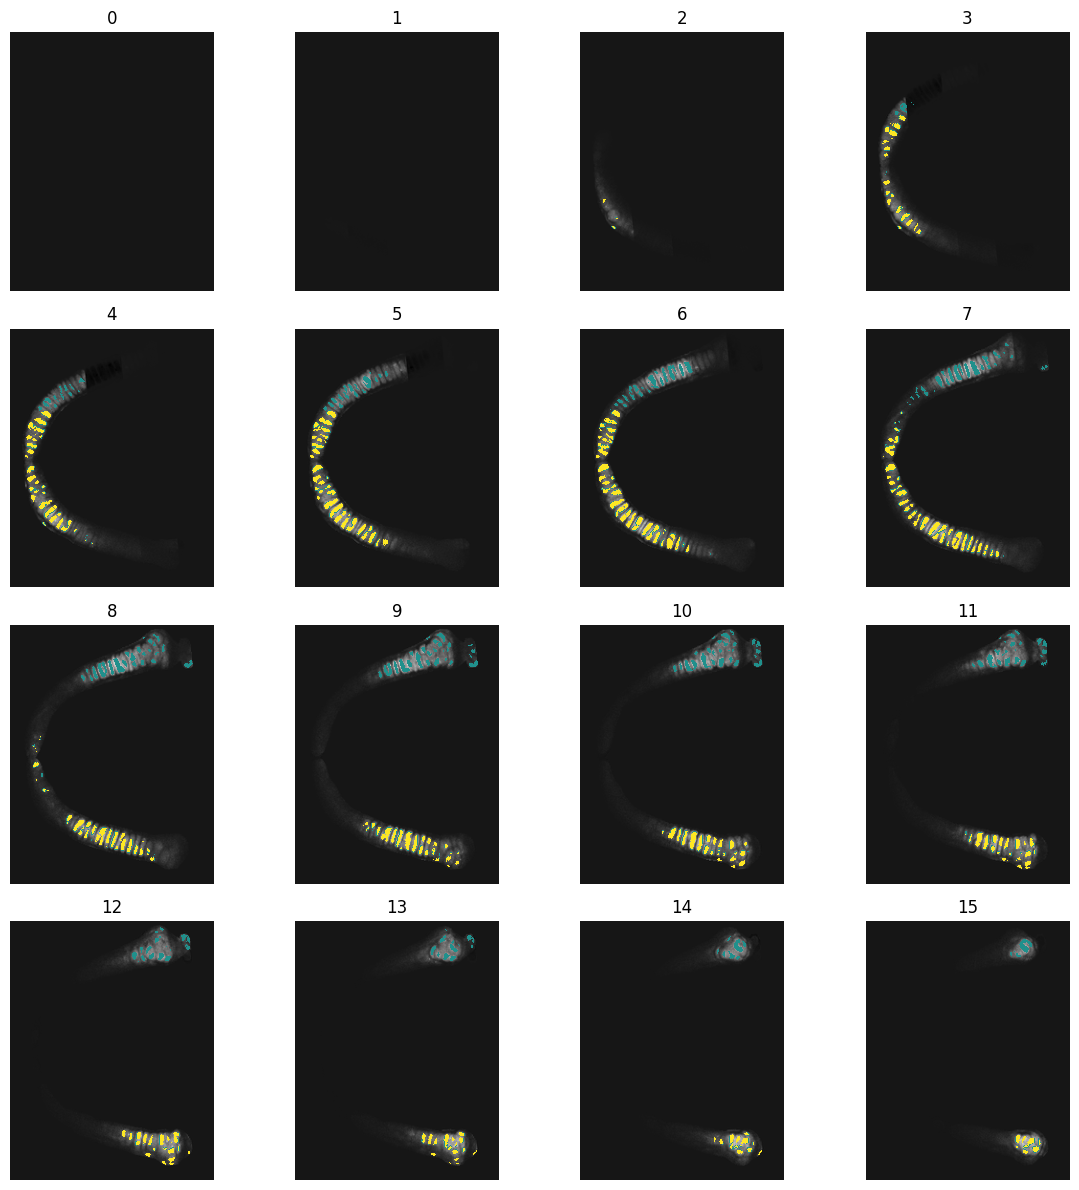

In [3]:
"""
Display two images I'm using for training

"""

import os
import numpy as np
from dev import plot, util

folder = os.path.join(util.userconf()["rdsf_dir"], "Yushi/Videos/theta_1/Code/segmenter/notebooks/projects/20180701_cell_segment/")
img_path = folder + "jaw_raw_image.npy"
mask_path = folder + "jaw_labels.npy"

img = np.load(img_path)
mask = np.load(mask_path)

# Convert the mask to labels
mask[(mask < 32) & (mask > 0)] = 1
mask[mask >= 32] = 2

img = np.transpose(img, (2, 0, 1))
mask = np.transpose(mask, (2, 0, 1))

plot.plot_arr(img, mask)

In [4]:
"""
Ignore all that and use a brain MRI dataset

"""

import torch.utils
import torchio as tio
from dev import image_io

transform = image_io.random_transforms()

subjectdataset = tio.datasets.ixi.IXITiny(
    root="tmp_data/", transform=transform, download=True
)

# This is slow and bad
indices = np.arange(len(subjectdataset))
np.random.shuffle(indices)
train_idx, val_idx, test_idx = np.split(
    indices, [int(0.8 * len(indices)), len(indices) - 1]
)

print(len(train_idx), len(val_idx), len(test_idx))


train_data = tio.SubjectsDataset([subjectdataset[i] for i in train_idx])
val_data = tio.SubjectsDataset([subjectdataset[i] for i in test_idx])
test_data = tio.SubjectsDataset([subjectdataset[i] for i in train_idx])

del subjectdataset

len(train_data), len(val_data), len(test_data)

Root directory for IXITiny found: tmp_data
452 113 1


(452, 1, 452)

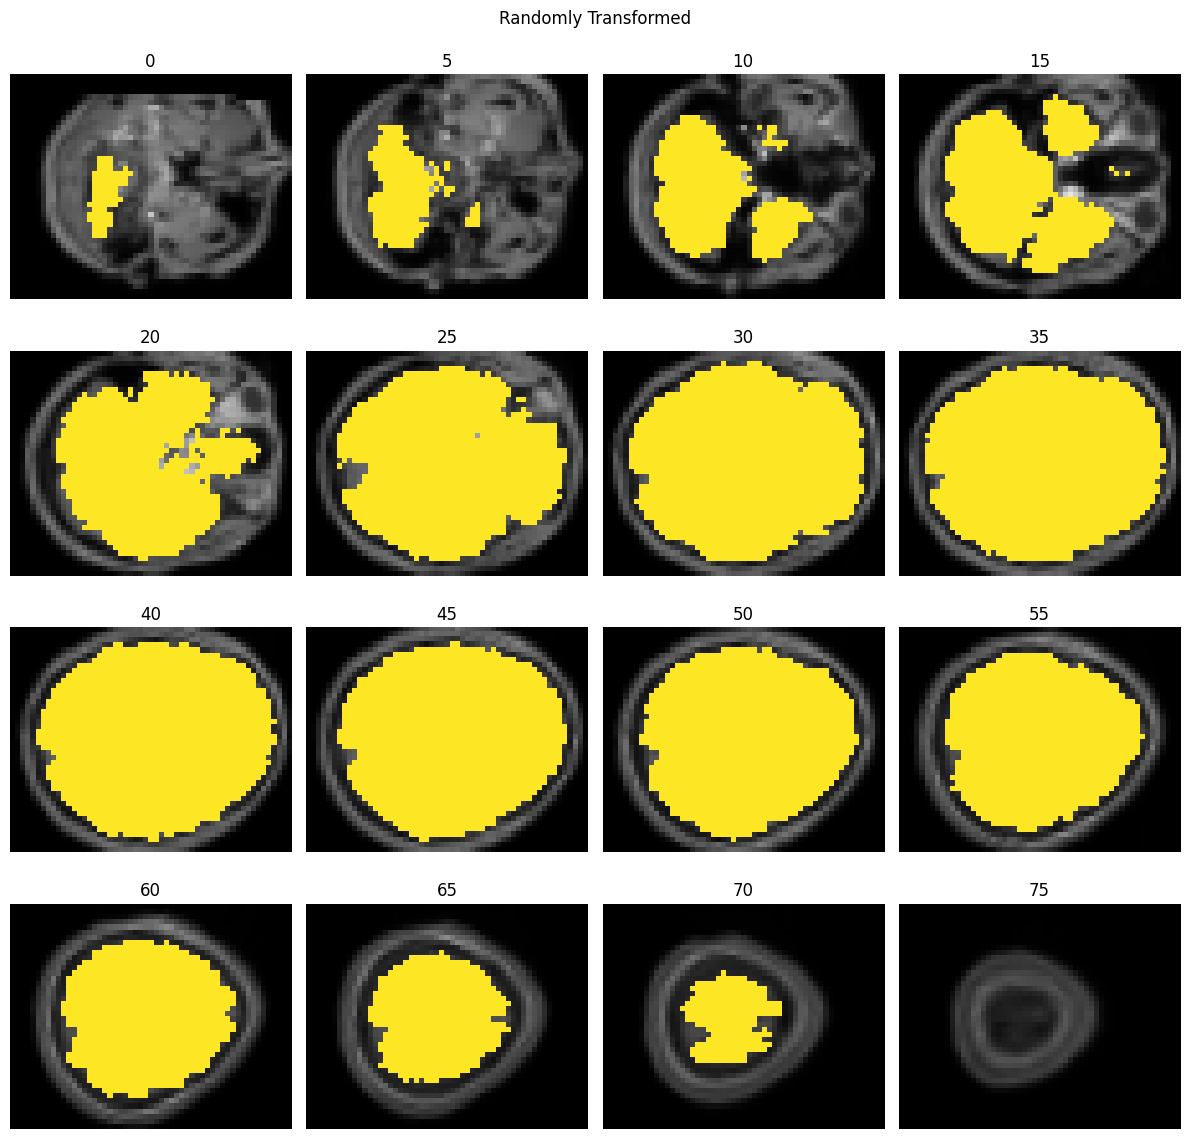

In [5]:
fig, _ = plot.plot_arr(
    image_io.pytorch2img(train_data[0].image.data.squeeze()),
    image_io.pytorch2img(train_data[0].label.data.squeeze()),
)
fig.suptitle("Randomly Transformed")
fig.tight_layout()


In [7]:
""" Create a DataLoader"""

import torch
from dev.util import userconf

uconf = userconf()
patch_size = [int(x) for x in uconf["patch_size"].split(",")]
print(f"Patch size: {patch_size}")


def dataloader(dataset: tio.SubjectsDataset):
    # Choose the probability of patches being centred on each value
    label_probs = {0: 1, 1: 1, 2: 1}
    patch_sampler = tio.LabelSampler(
        patch_size=patch_size, label_probabilities=label_probs
    )
    patches = tio.Queue(
        dataset,
        max_length=10000,
        samples_per_volume=6,
        sampler=patch_sampler,
        num_workers=10,
    )

    return torch.utils.data.DataLoader(
        patches,
        batch_size=uconf["batch_size"],
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )

train_loader = dataloader(train_data)
val_loader = dataloader(val_data)
test_loader = dataloader(test_data)

Patch size: [32, 32, 32]


In [6]:
"""
Load a model

"""

from dev.segmentation import model as lib_model

model = lib_model.model()
# lib_model.draw_model(model, "model.pdf")

In [8]:
"""
Create an optimiser + choose a loss function

"""

from monai.losses import TverskyLoss

optimiser = lib_model.optimiser(model)
loss = TverskyLoss(include_background=True, to_onehot_y=True, alpha=0.2)

optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.5e-05
    maximize: False
    weight_decay: 0
)

In [9]:
import warnings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    # Yellow text
    yellow = "\033[33m"
    clear = "\033[0m"
    warnings.warn(f"{yellow}This might not be what you want!{clear}")
print(f"Using {device} device")

_ = model.to(device)

Using cuda device


In [10]:
model, train_loss, val_loss = lib_model.train(
    model,
    optimiser,
    loss,
    train_loader,
    val_loader,
    device=device,
    epochs=20,
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=2),
    notebook=True
)

  0%|                                                                                                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|████████████▏                                                                                                                                                                                                                                       | 1/20 [00:26<08:19, 26.26s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|████████████████████████▍                                                                                                                                                                                                                           | 2/20 [00:53<08:04, 26.93s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|████████████████████████████████████▌                                                                                                                                                                                                               | 3/20 [01:21<07:42, 27.20s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▊                                                                                                                                                                                                   | 4/20 [01:49<07:19, 27.45s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|█████████████████████████████████████████████████████████████                                                                                                                                                                                       | 5/20 [02:16<06:52, 27.51s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 6/20 [02:44<06:25, 27.56s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 7/20 [03:12<05:59, 27.62s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 8/20 [03:39<05:31, 27.66s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 9/20 [04:07<05:04, 27.67s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 10/20 [04:35<04:37, 27.73s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 11/20 [05:02<04:09, 27.70s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 12/20 [05:30<03:41, 27.74s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 13/20 [05:58<03:14, 27.73s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 14/20 [06:26<02:46, 27.70s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 15/20 [06:53<02:18, 27.73s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 16/20 [07:21<01:50, 27.73s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 17/20 [07:49<01:23, 27.72s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 18/20 [08:17<00:55, 27.77s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 19/20 [08:45<00:27, 27.77s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:12<00:00, 27.63s/it]


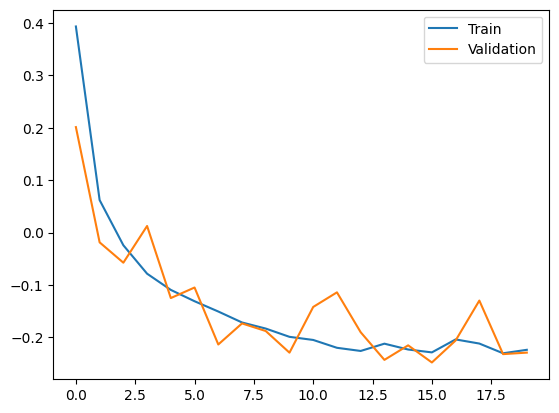

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()

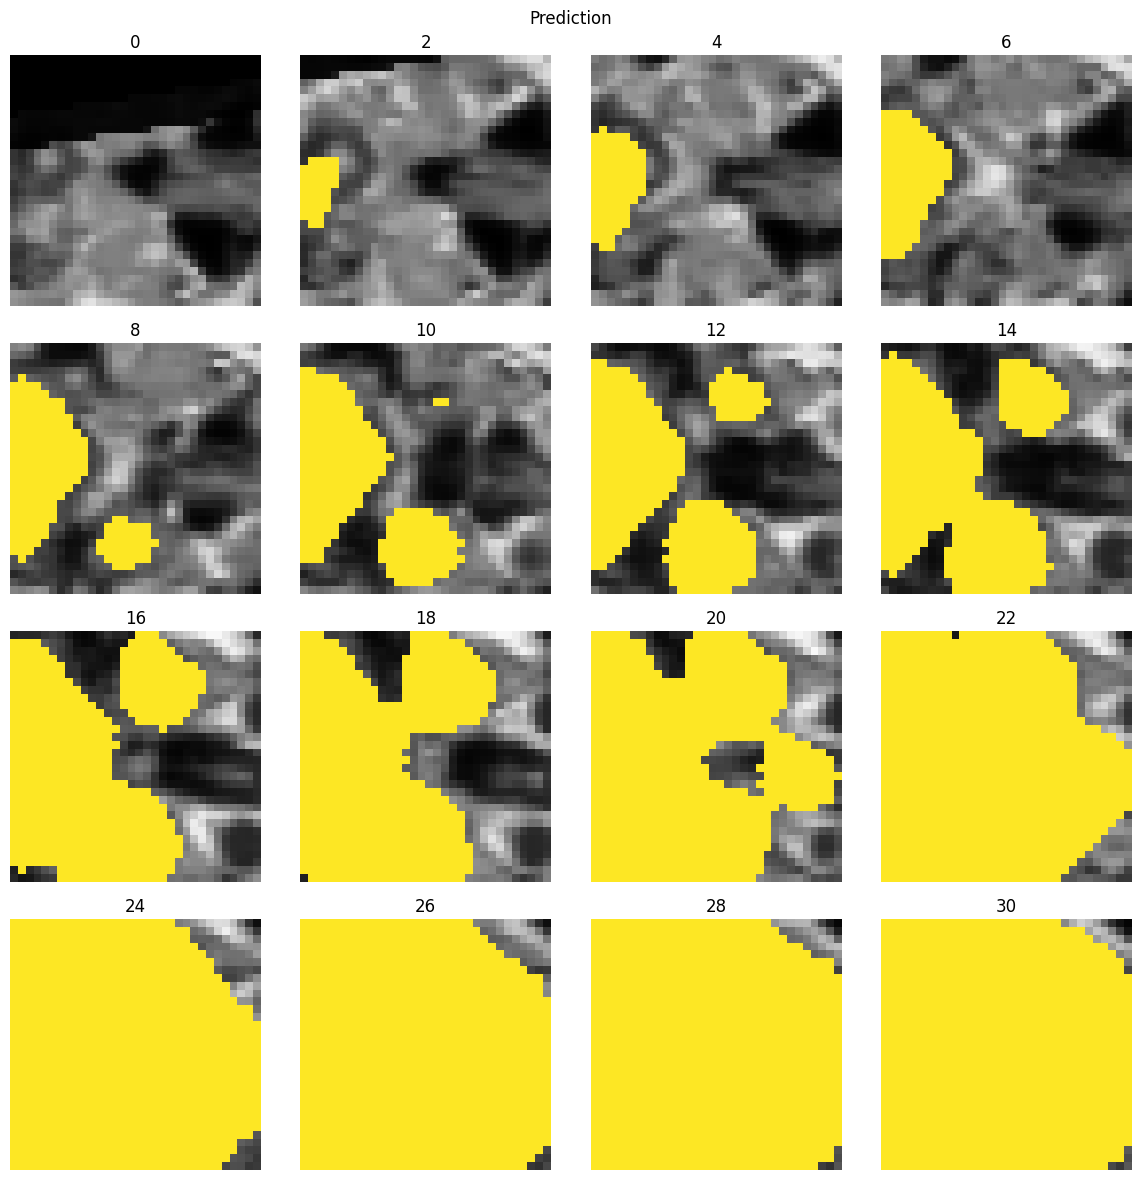

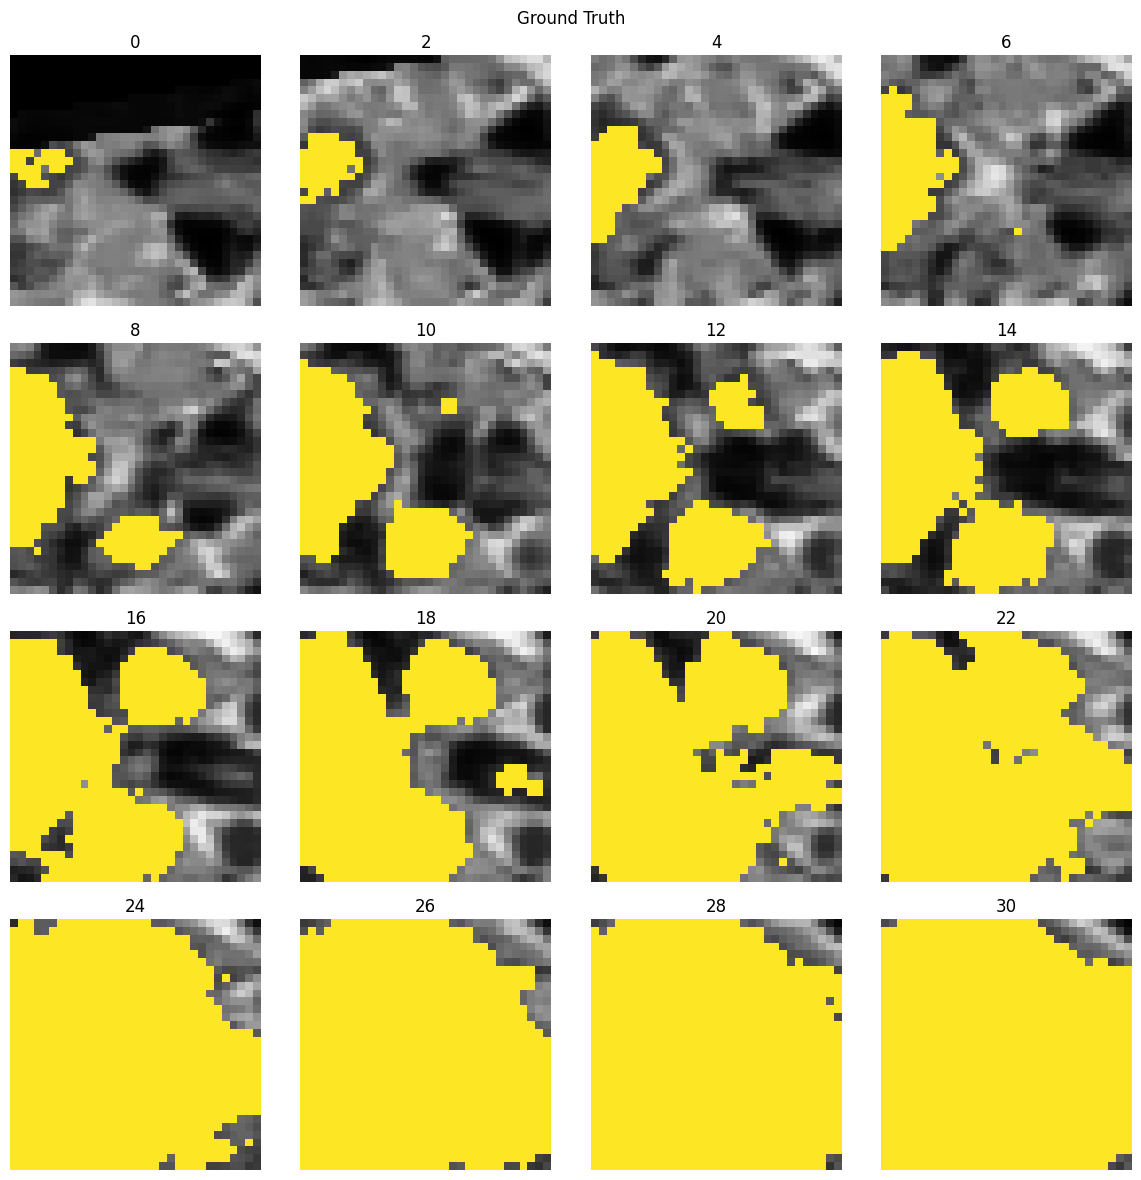

In [12]:
"""
Show the result on the test data

"""
print(test_loader)
test_patch = next(iter(test_loader)) if not "test_patch" in locals() else test_patch

test_data = test_patch["image"]["data"]
test_label = test_patch["label"]["data"]

prediction = model(test_data.to(device)).to("cpu").detach()

# Convert one-hot to labels
prediction = prediction.argmax(dim=1)

# Convert to numpy
test_data = test_data.squeeze(1).numpy()
test_label = test_label.squeeze(1).numpy()

# Extract just one patch
i = 0
prediction = prediction[i]
test_data = test_data[i]
test_label = test_label[i]

fig, _ = plot.plot_arr(test_data, prediction)
fig.suptitle("Prediction")
fig.tight_layout()

fig, _ = plot.plot_arr(test_data, test_label)
fig.suptitle("Ground Truth")
fig.tight_layout()